# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [1]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from src.util import (plot_mesh, create_trajectory, create2DAnimation, define_mesh_obj, plot_mesh_permarray)

## Erstellung der Simulationsdaten

In [9]:
""" 0. build mesh """
n_el = 32
mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos 
mesh_obj.print_stats()                     
protocol_obj = protocol.create(n_el, dist_exc=n_el//2, step_meas=1, parser_meas="meas_current")   

def calculateData(mesh):
    ex_line = protocol_obj.ex_mat[0].ravel() 
    fwd = Forward(mesh)
    f = fwd.solve(ex_line)  
    fwd = EITForward(mesh_obj, protocol_obj)
    f= np.real(f) 
    v = fwd.solve_eit(perm=mesh.perm)   
    return (f, v)

def createAnomaly(traj, base_points, r, r_path, r_path_variations, bound, added_noise):
    """
    Create anomaly with point count scaled by radius
    
    Parameters:
    traj (str): Trajectory type
    base_points (int): Number of points for reference radius (0.2)
    r (float): Radius of anomaly
    r_path (float): Radius of trajectory path
    r_path_variations (bool): Whether to vary path radius
    bound (float): Boundary parameter
    added_noise (bool): Whether to add noise
    """
    # Debug: Print input parameters
    print(f"Starting createAnomaly with parameters:")
    print(f"traj: {traj}, base_points: {base_points}, r: {r}, r_path: {r_path}")
    print(f"r_path_variations: {r_path_variations}, bound: {bound}, added_noise: {added_noise}")
    
    # Calculate scaled number of points based on path radius
    # Using 0.2 as reference radius
    ref_radius = 0.2
    scale_factor = r_path / ref_radius
    Nsteps = int(round(base_points * scale_factor))
    
    print(f"Scaled points: {Nsteps} (scale factor: {scale_factor:.2f})")
    
    # Create trajectory with scaled points
    center_pos = create_trajectory(traj, r_path, Nsteps)
    
    mesh_new_list = []
    perm = 0.9
    
    # Use tqdm for progress display
    from tqdm import tqdm
    for i, center in enumerate(tqdm(center_pos, desc="Processing points")):
        anomaly = PyEITAnomaly_Circle(center, r=r, perm=perm)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=0.1)
            
        if added_noise:
            anomaly_mesh.perm = anomaly_mesh.perm + np.random.normal(
                scale=0.05, 
                size=anomaly_mesh.perm_array.shape[0]
            )
            
        f, v = calculateData(anomaly_mesh)
            
        mesh_dict = {
            "mesh": anomaly_mesh,
            "x": center[0],
            "y": center[1],
            "radius": r,
            "perm_init": perm,
            "f": f,
            "v": v,
            "anomaly": anomaly,
        }
        mesh_new_list.append(mesh_dict)
    
    return mesh_new_list

2D mesh status:
1486 nodes, 2840 elements


## Erstellt Plot der Trajektorie

In [3]:
def checkTraj(mesh_new_list, Nstep):
    plt.figure(figsize=(10, 10))
    
    pts = mesh_new_list[0]["mesh"].node
    tri = mesh_new_list[0]["mesh"].element
    
    plt.triplot(pts[:, 0], pts[:, 1], tri, color='gray', alpha=0.5)
    
    x_coords = [mesh_dict["x"] for mesh_dict in mesh_new_list]
    y_coords = [mesh_dict["y"] for mesh_dict in mesh_new_list]
    
    plt.plot(x_coords, y_coords, '-', color='blue', alpha=0.6, 
             label='Trajektorie', linewidth=2)
    
    num_images = Nstep
    step_size = max(Nstep // num_images, 1)  

    indices = np.linspace(0, Nstep - 1, num_images, dtype=int)

    for i in indices:
        plt.plot(x_coords[i], y_coords[i], 'ro', markersize=6)
        
        circle = Circle((x_coords[i], y_coords[i]), 
                       radius=mesh_new_list[i]["radius"],
                       fill=False, 
                       color='red',
                       alpha=0.3)
        plt.gca().add_patch(circle)
    
    if hasattr(mesh_new_list[0]["mesh"], 'el_pos'):
        el_pos = mesh_new_list[0]["mesh"].el_pos
        plt.plot(pts[el_pos, 0], pts[el_pos, 1], 'ko', 
                markersize=6, label='Elektroden')
    
    plt.axis('equal')
    
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.title('EIT Mesh mit Anomalie-Trajektorie')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    

## Ruft Funktionen auf und speichert Simulationsdaten

In [8]:
def generateData (traj,Nbase,r_anomaly,r_path, r_path_variations, bound, added_noise, saveData,createGif):
    
    mesh_new_list = createAnomaly(traj, Nbase, r_anomaly, r_path, r_path_variations, bound, added_noise)
    if saveData: 
        
        base_dataset_folder = "data_set"
        os.makedirs(base_dataset_folder, exist_ok=True)

        base_name = "data"

        counter = 1
        folder_name = os.path.join(base_dataset_folder, base_name)
        
        
        while os.path.exists(folder_name):
            
            folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
            
            counter += 1
        os.makedirs(folder_name) 

        lookup_file_path = os.path.join(base_dataset_folder, "parameter_log.txt")
        ref_radius = 0.2
        scale_factor = r_path / ref_radius
        Nstep = int(Nbase * scale_factor)
        
        with open(lookup_file_path, 'a') as f:
            f.write(f"Folder: {folder_name}\n")
            f.write(f"Trajectory: {traj}\n")
            f.write(f"Nstep: {Nstep}\n")
            f.write(f"r_anomaly: {r_anomaly}\n")
            f.write(f"r_path: {r_path}\n")
            f.write(f"r_path_variantions: {r_path_variations}\n")
            f.write(f"bound: {bound} \n")
            f.write(f"added_noise: {added_noise}\n")
            f.write("-" * 40 + "\n")  # Trennlinie zwischen Einträgen    
      

        for i in range(len(mesh_new_list)):
            file_path = os.path.join(folder_name, f"sample_{i:06d}.npz")  
            np.savez(file_path, v=mesh_new_list[i]["v"], anomaly=mesh_new_list[i]["anomaly"], gamma = mesh_new_list[i]["mesh"].perm)

    if createGif==True:
        create2DAnimation(traj,mesh_new_list,protocol_obj,mesh_obj)  

    #plotMesh(mesh_new_list)

    checkTraj(mesh_new_list,Nstep)

    return mesh_new_list

## Hier kann Simulation ausgeführt und Parameter angepasst werden

Starting createAnomaly with parameters:
traj: Kreis, base_points: 6000, r: 0.15, r_path: 0.5
r_path_variations: False, bound: 0.1, added_noise: True
Scaled points: 15000 (scale factor: 2.50)


Processing points: 100%|██████████| 15000/15000 [51:45<00:00,  4.83it/s] 


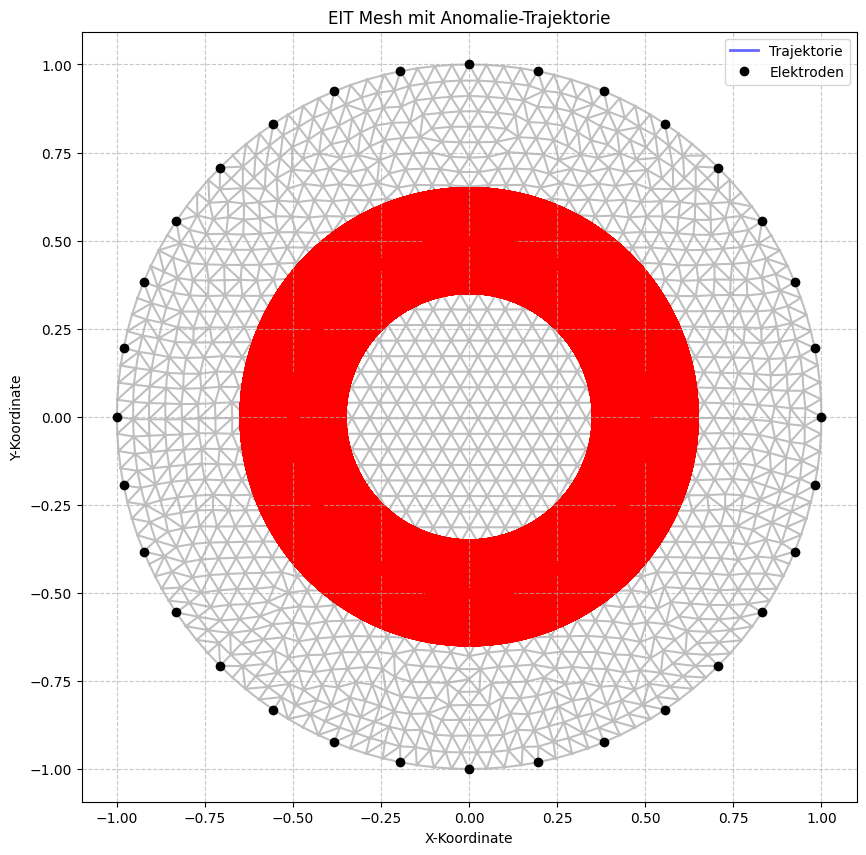

In [12]:
Nbase = 6000                 # Base points for r_path = 0.2
r_anomaly = 0.15            # Radius of anomaly
r_path = 0.5               # Radius of trajectory
traj = "Kreis"
saveData = True
createGif = False
r_path_variations = False
bound = 0.1
added_noise = True


mesh_new_list = generateData(traj, Nbase, r_anomaly, r_path, r_path_variations, bound, added_noise, saveData,createGif)

In [6]:
#SNR of Noise mit einbauen!
#Helix mit variablen Windungsdichten, und Radius 
#nan Werte kannst du aus dem Array schmeißen, würde ich dann nur in der Arbeit erwähnen, dass nur die werte mit einbezogen werden
#konnten, wo eine Reconstruction erfolgt ist 